Definition of Gentrification: a process where wealthy people move into an area, raising rent and housing prices and pushing out the original residents displace low-income families or, more often, prevent low-income families from moving into previously affordable neighborhoods

Why we chose this as our project:
Boston is a “collegetown”, with 27 colleges & 50,000 students in the city of Boston
Boston is a city with severe gentrification (Smith)
ranked 3rd most in the nation
21.3% of the city is gentrified from 2013-2017

Hypothesis : Students may move to a neighborhood to attend a college in an adjacent neighborhood, thus raising the living standard of that area. The more college students, the higher prices.

Our research question: Does the presence of colleges in a tract affect change in median gross rent of that tract?

Tools: pandas, geopandas, censusdata API, excel, mathplotlib

In [ ]:
!pip install censusdata

In [36]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore") #to surpress DataFrame copy warnings
import censusdata

We first had to figure out how to pull census data for Massachusetts. The state number for MA is 25.

In [37]:
states2014 = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
print(states2014['Massachusetts'])
states2019 = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2019)
print(states2019['Massachusetts'])

Summary level: 040, state:25
Summary level: 040, state:25


We also had to figure out how to pull census data for Boston specifically. The county number for Suffolk is 025. We determined that Boston is considered Suffolk County.

In [38]:
counties2014 = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2014)
print(counties2014)
counties2019 = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2019)
print(counties2019)

{'Barnstable County, Massachusetts': censusgeo((('state', '25'), ('county', '001'))), 'Berkshire County, Massachusetts': censusgeo((('state', '25'), ('county', '003'))), 'Plymouth County, Massachusetts': censusgeo((('state', '25'), ('county', '023'))), 'Norfolk County, Massachusetts': censusgeo((('state', '25'), ('county', '021'))), 'Nantucket County, Massachusetts': censusgeo((('state', '25'), ('county', '019'))), 'Suffolk County, Massachusetts': censusgeo((('state', '25'), ('county', '025'))), 'Dukes County, Massachusetts': censusgeo((('state', '25'), ('county', '007'))), 'Middlesex County, Massachusetts': censusgeo((('state', '25'), ('county', '017'))), 'Bristol County, Massachusetts': censusgeo((('state', '25'), ('county', '005'))), 'Hampden County, Massachusetts': censusgeo((('state', '25'), ('county', '013'))), 'Essex County, Massachusetts': censusgeo((('state', '25'), ('county', '009'))), 'Franklin County, Massachusetts': censusgeo((('state', '25'), ('county', '011'))), 'Worcest

We then needed to figure out the codes for the variables that corresponded to total population and median gross rent. We used google for this.

In [39]:
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B01003')) #total population
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B25064')) #median gross rent

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B01003_001E  | B01003.  Total Population      | Total                                                    | int  
-------------------------------------------------------------------------------------------------------------------
Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B25064_001E  | B25064.  Median Gross Rent (Do | Median gross rent                                        | int  
-------------------------------------------------------------------------------------------------------------------


To avoid issues with running cells out of order and creating mutation issues, we made a function that sets all dateframes to a known state. We used our findings above (about state, county, and variable codes) to pull the information we wanted from the Census API, from the 5 year estimate 2010-2014 and the 5 year estimate 2015-2019. However, when we pulled the data, it was not in the form we wanted; it was a dataframe where each row represented a block instead of a tract. Since blocks are subgroups of tracts, there were multiple rows that represented the same tract. In addition, there was no column for CT-ID, but rather a long string that contained pieces of a CT-ID. So we needed to create another method to convert the raw data into usable data, where each row represented a unique tract instead of block, with the columns still describing total population and median gross rent, but for the tract instead of the block. 

In [33]:
boston_data_2014  = ''
boston_data_2019 = ''

#sets all dataframes to a known state
def initData():
    global boston_data_2014
    global boston_data_2019
    
    boston_data_2014 = censusdata.download('acs5', 2014,
           censusdata.censusgeo([('state', '25'),
                                 ('county', '025'),
                                 ('block group', '*')]),
          ['B01003_001E', 'B25064_001E'])


    boston_data_2014 = convert_raw_census(boston_data_2014)
    
    boston_data_2019 = censusdata.download('acs5', 2019,
           censusdata.censusgeo([('state', '25'),
                                 ('county', '025'),
                                 ('block group', '*')]),
          ['B01003_001E', 'B25064_001E'])

    boston_data_2019 = convert_raw_census(boston_data_2019)
    



Our first step of converting raw data was renaming the column names from the raw data, which were previously just numebrs and letters. The next order of business was dealing with missing data. We made the decision that if a given row did not have a population (nan) we gave it a value of 0. We did the same for rows without median gross rent. In addition, we encountered an error where certain rows contained median gross rent values that were negative. So we set those to 0 as well. Next, we created the CT-ID column by using string manipulation on the corresponding row in the raw tract column. Finally, we aggregated block data into tract data. Given that multiple blocks could correspond to the same CT-ID, we used group by on CT-ID, summing the populations and taking a weighted sum of the median gross rents for the blocks in the given CT-ID group. This gave us two dataframes: one with CT-ID and total population, the other with CT-ID and median gross rent. In both, each row represented a unique tract, not a block. We then merged these two by CT-ID, thus completing our conversion from raw census data to the form we wanted.

In [40]:
#for the given df, grouped by CT-ID, sums the population
def total_pop(df):
    return df['TotalPop'].sum()

#for the given df, grouped by CT-ID, finds the weighted sum of median gross rent 
def weighted_gross_rent(df):
    df.reset_index(inplace=True)
    #the total population in the blocks in this CT-ID group
    normal = total_pop(df)
    sum = 0
    for i in range(df.shape[0]):
        #the population of one block
        pop = df['TotalPop'][i]
        #the proportion of this block 
        weight = pop / normal
        #the median gross rent of this block
        rent = df['Median_Gross_Rent'][i]
        #weighted 
        sum += rent * weight
    return sum


#given a df of raw boston census data from a given year,
#returns a new dataframe with updated column names and a new CT-ID column
def convert_raw_census(df):
    df.reset_index(inplace=True)
    df.rename(columns={"B01003_001E": "TotalPop",
                           "B25064_001E": "Median_Gross_Rent", "index": "raw_tract"}, inplace=True)
    
    #a design decisions
    df["TotalPop"] = df["TotalPop"].fillna(0)
    df["Median_Gross_Rent"] = df["Median_Gross_Rent"].fillna(0)
    
    
    
    #make a new column for CT_ID_10, initialized as a copy 
    df['CT-ID-10'] = df['raw_tract']
    
    for i in range(df.shape[0]):
        
        #dealing with negative rents
        #by setting them to 0
        if df['Median_Gross_Rent'][i] < 0:
            df['Median_Gross_Rent'][i] = 0
            
        #the current CT-ID    
        curr = df['CT-ID-10'][i]
        curr = str(curr)
        
        #where the tract ID is located
        start = curr.index('tract') + 6
        end = start + 6
        
        #substring
        tract_ID  = curr[start: end]
 
        #all have the same state and county ID with prefix 25025
        CT_ID = "25025" + str(tract_ID)
        CT_ID = int(CT_ID)
        
        #replace the entries of CT_ID_10 with the actual value
        df['CT-ID-10'][i] = CT_ID
    
    total_pop_table = df.groupby('CT-ID-10').apply(total_pop)
    max_rent_table = df.groupby('CT-ID-10').apply(weighted_gross_rent)
    total_pop_df = total_pop_table.rename_axis('CT-ID-10').reset_index(name='TotalPop')
    max_rent_df = avg_rent_table = max_rent_table.rename_axis('CT-ID-10').reset_index(name='Median_Gross_Rent')
    result = total_pop_df.merge(max_rent_df, how = 'left', on = 'CT-ID-10')
    return result
    

We tested our raw data conversion on the 2010-2014 pull, and it was a success.

In [41]:
initData()
print("Total population of Suffolk County 2014: " + str(boston_data_2014.TotalPop.sum()))
print("Total tracts: " + str(boston_data_2014.shape[0]))
boston_data_2014.head()

Total population of Suffolk County 2014: 747928
Total tracts: 204


,CT-ID-10,TotalPop,Median_Gross_Rent
0,25025000100,3264,1514.267770
1,25025000201,3073,1691.745200
2,25025000202,3482,1426.505744
3,25025000301,2437,1682.533032
4,25025000302,2673,1741.272727


We then tested our raw data conversion on the 2014-2019 pull, and it was also a success.

In [42]:
initData()
print("Total population of Suffolk County 2019: " + str(boston_data_2019.TotalPop.sum()))
print("Total tracts: " + str(boston_data_2019.shape[0]))
boston_data_2019.head()

Total population of Suffolk County 2019: 796605
Total tracts: 204


,CT-ID-10,TotalPop,Median_Gross_Rent
0,25025000100,5884,1786.764616
1,25025000201,4125,2297.036364
2,25025000202,4461,1653.422551
3,25025000301,3074,2348.629473
4,25025000302,3447,2254.574993


The next thing we did was generate our college data, by reading the excel file we made as a dataframe. We made the decision to drop all rows that has Na for net price. (To clarify, net price is the cost of attending the school factoring in finanical aid/scholarships). We also used string manipulation to convert all values in the net price column to integers. 

In [43]:
college_data = pd.read_excel("collegesInBoston.xlsx")

#we cannot analyze a college if it has missing data 
college_data = college_data.dropna(subset = ['Net Price **'])

college_data.reset_index(inplace=True)

#converting the prices from string format to integer format
for row in range(len(college_data)):
    price_as_string = str(college_data['Net Price **'][row])
    if "," in price_as_string:
        comma_index = price_as_string.index(",")
        clean = price_as_string[1: comma_index] + price_as_string[comma_index+1:]
    else:
        clean = price_as_string[1:]
    college_data['Net Price **'][row] = int(clean)

college_data.head()

,index,Name,Address,Website,Type,Awards offered,Campus setting,Campus housing,Student population,Undergraduate students,Graduation Rate,Transfer-Out Rate,Cohort Year *,Net Price **,Largest Program,IPEDS ID,OPE ID,CT-ID-10
0,0,North Bennet Street School,"150 North Street, Boston, Massachusetts 02109",www.nbss.edu/,"2-year, Private not-for-profit",One but less than two years certificate;Two bu...,City: Large,No,157,157.0,72%,NaN,Fall 2016,32019,Furniture Design and Manufacturing,167297,2197900,25025030400
1,1,Suffolk University,"73 Tremont St., Boston, Massachusetts 02108-3901",https://www.suffolk.edu/,"4-year, Private not-for-profit",One but less than two years certificate;Associ...,City: Large,Yes,7169,4862.0,58%,29%,Fall 2013,33105,-,168005,221800,25025070101
2,2,Empire Beauty School-Boston,"30 West Street, Boston, Massachusetts 02111",www.empire.edu/,"< 2-year, Private for-profit",One but less than two years certificate,City: Large,No,139,139.0,58%,NaN,2016-17,17053,"Cosmetology/Cosmetologist, General",164845,817807,25025010701
3,3,Boston Architectural College,"320 Newbury Street, Boston, Massachusetts 0211...",www.the-bac.edu/,"4-year, Private not-for-profit",Less than one year certificate;Bachelor's degr...,City: Large,Yes,737,364.0,13%,33%,Fall 2013,26640,-,164872,396600,25025010701
4,4,Emmanuel College,"400 The Fenway, Boston, Massachusetts 02115",www.emmanuel.edu/,"4-year, Private not-for-profit",Bachelor's degree;Postbaccalaureate certificat...,City: Large,Yes,2222,2112.0,66%,NaN,Fall 2013,29946,-,165671,214700,25025010300


However, similar to the block issue from the raw census data, each row in our college dataframe did not represent a unique tract, but rather an individual college. Therefore, multiple rows could have the same CT-ID if multiple colleges were located there. To deal with this, we used a similar conversion process that we did on the raw census data. We grouped by CT-ID, taking the sum of the student populations and the average net price. This gave us two dataframes with rows representing unique tracts, one  with CT-ID and total student population, and the other with CT-ID and average net price. We then merged these two by CT-ID, thus completing our conversion.

In [44]:
#the average net price
def avg_price(df):
    count = df.shape[0]
    return df["Net Price **"].sum() / count

#the sum of student populations for all colleges in the given CT-ID group
def total_students(df):
    return df['Student population'].sum()

avg_tuition_prices_table = college_data.groupby('CT-ID-10').apply(avg_price)

total_students_table = college_data.groupby('CT-ID-10').apply(total_students)

avg_tuition_prices_per_tract = avg_tuition_prices_table.rename_axis('CT-ID-10').reset_index(name='avg_net_price')

total_students_per_tract = total_students_table.rename_axis('CT-ID-10').reset_index(name='total_student_pop')

In [45]:
avg_tuition_prices_per_tract.head()

,CT-ID-10,avg_net_price
0,25025010103,29479.00
1,25025010300,31271.75
2,25025010405,42281.00
3,25025010701,21846.50
4,25025010801,23981.00


In [46]:
total_students_per_tract.head()

,CT-ID-10,total_student_pop
0,25025010103,33720
1,25025010300,18218
2,25025010405,30049
3,25025010701,876
4,25025010801,1628


We displayed our converted college dataframe, which was a success. 

In [47]:
relevant_college_data = avg_tuition_prices_per_tract.merge(total_students_per_tract, how = 'left', on = 'CT-ID-10')

relevant_college_data.head()

,CT-ID-10,avg_net_price,total_student_pop
0,25025010103,29479.00,33720
1,25025010300,31271.75,18218
2,25025010405,42281.00,30049
3,25025010701,21846.50,876
4,25025010801,23981.00,1628


At this point, we needed to merge the converted census dataframes with the converted college dataframe by CT-ID. However, we could not do this just yet, because the census dataframes had far more rows (more unique CT-ID's) than the college dataframe. To handle this, we filtered out all rows from the census dataframes that contained CT-ID's not represented in the college dataframe.

In [48]:
initData()
#all CT-ID's listed in college data
college_tracts = relevant_college_data['CT-ID-10'].tolist()


#returns a filtered version of the given census data
#that contains only CT-ID's listed in college data 
def filterCensus(df):
    for n in range(len(df)):
        test = df['CT-ID-10'][n]
        if not test in college_tracts:
            df = df.drop([n])
    return df

boston_data_2014 = filterCensus(boston_data_2014)

boston_data_2019 = filterCensus(boston_data_2019)

print("The Boston census data now contains only " + str(boston_data_2014.shape[0]) + " relevant tracts")

The Boston census data now contains only 14 relevant tracts


Now that the CT-ID's matched, we were able to merge the 2010-2014 census dataframe and the 2014-2019 census dataframe with the college dataframe.

In [49]:
#merges the given processed census data with the relevant college data
#over the CT-ID column
initData()

def finalize(df):
    result = relevant_college_data.merge(df, how = 'left', on = 'CT-ID-10')
    return result

full_df_2014 = finalize(boston_data_2014)

full_df_2019 = finalize(boston_data_2019)


In [50]:
full_df_2014.rename(columns={"Median_Gross_Rent": "Median_Gross_Rent_2014"}, inplace=True)
full_df_2014.head()


,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2014
0,25025010103,29479.00,33720,3704,1060.298596
1,25025010300,31271.75,18218,5202,1404.483660
2,25025010405,42281.00,30049,5814,549.406261
3,25025010701,21846.50,876,2954,1881.977319
4,25025010801,23981.00,1628,3259,1725.560295


In [51]:
full_df_2019.rename(columns={"Median_Gross_Rent": "Median_Gross_Rent_2019"}, inplace=True)
full_df_2019.head()

,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2019
0,25025010103,29479.00,33720,3686,1717.544493
1,25025010300,31271.75,18218,5351,1404.026163
2,25025010405,42281.00,30049,6008,722.916112
3,25025010701,21846.50,876,2383,2059.597566
4,25025010801,23981.00,1628,3002,2176.054297


Our last step was to create the column for percent change in rent. To do this, we took a slice of the 2014-2019 census dataframe where we only kept the columns CT-ID and Median Gross Rent. We then merged this slice with the pre-existing merge between the 2010-2014 census dataframe and the college dataframe. To calculate percent change in rent, we used the formula (final - initial) / initial, with initial being the median gross rent for 2010-2014 and final being the median gross rent for 2014-2019. 

In [56]:
df_2019_rent = pd.DataFrame(full_df_2019, columns = ['CT-ID-10', 'Median_Gross_Rent_2019']) 
df_2014_19 = full_df_2014.merge(df_2019_rent, how = 'left', on = 'CT-ID-10')
df_2014_19['percent_change_in_rent'] = (df_2014_19['Median_Gross_Rent_2019'] - df_2014_19['Median_Gross_Rent_2014']) / df_2014_19['Median_Gross_Rent_2014']
df_2014_19.head()


,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2014,Median_Gross_Rent_2019,percent_change_in_rent
0,25025010103,29479.00,33720,3704,1060.298596,1717.544493,0.619869
1,25025010300,31271.75,18218,5202,1404.483660,1404.026163,-0.000326
2,25025010405,42281.00,30049,5814,549.406261,722.916112,0.315813
3,25025010701,21846.50,876,2954,1881.977319,2059.597566,0.094380
4,25025010801,23981.00,1628,3259,1725.560295,2176.054297,0.261071


Now that we had all the statistics we wanted in one dataframe, we could create graphs that would answer our initial research question. Our first graph was average net price vs percent change in rent from 2014-2019. Again, each data point represents a unique tract.

Text(0.5, 1.0, 'Relationship between average net price and percent change in rent from 2014-2019 per tract')

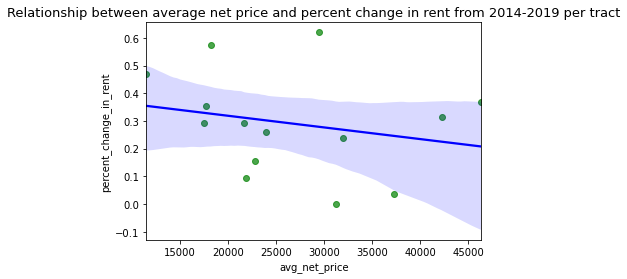

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x='avg_net_price', y='percent_change_in_rent', scatter_kws={"color": "green", 'alpha': 0.7}, line_kws={"color": "blue"}, data=df_2014_19)
plt.title('Relationship between average net price and percent change in rent from 2014-2019', fontsize = 13)

Our second graph was average net price vs percent change in rent from 2014-2019

Text(0.5, 1.0, 'Relationship between total student population and percent change in rent from 2014-2019')

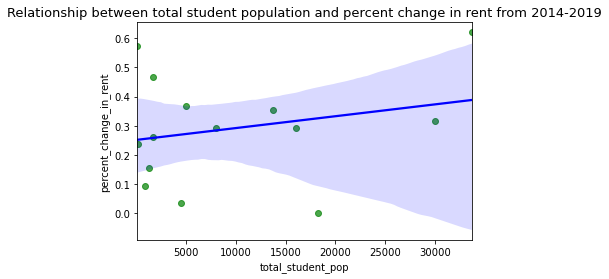

In [62]:
sns.regplot(x='total_student_pop', y='percent_change_in_rent', scatter_kws={"color": "green", 'alpha': 0.7}, line_kws={"color": "blue"}, data=df_2014_19)
plt.title('Relationship between total student population and percent change in rent from 2014-2019', fontsize = 13)

Text(0.5, 1.0, 'Relationship Between Total Population and change in rent')

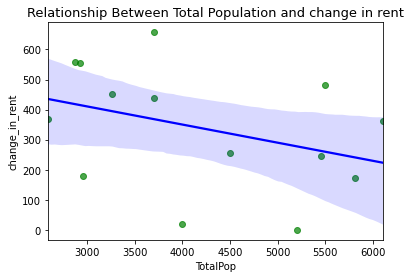

In [29]:
sns.regplot(x='TotalPop', y='change_in_rent', scatter_kws={"color": "green", 'alpha': 0.7}, line_kws={"color": "blue"}, data=df_2014_19)
plt.title('Relationship Between Total Population and change in rent', fontsize = 13)

To measure exact correlations, we created a correlation matrix as shown below. 

In [30]:
full_df_2014.corr()

,CT-ID-10,avg_net_price,total_student_pop,TotalPop,Median_Gross_Rent_2015
CT-ID-10,1.000000,-0.319433,-0.444361,0.325095,-0.351979
avg_net_price,-0.319433,1.000000,0.296353,0.390140,-0.555468
total_student_pop,-0.444361,0.296353,1.000000,0.206624,-0.256332
TotalPop,0.325095,0.390140,0.206624,1.000000,-0.549469
Median_Gross_Rent_2015,-0.351979,-0.555468,-0.256332,-0.549469,1.000000
